# Info

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

# Libraries Import

In [54]:
import glob
import cv2
import tqdm

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
import kagglehub

In [57]:
import os
from collections import Counter
import random
import re
import json
import pickle

In [58]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, Concatenate
from tensorflow.keras.layers import AvgPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model
import tensorflow as tf


In [59]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [60]:
from concurrent.futures import ThreadPoolExecutor


# Constants

In [61]:
IMG_W = 512
IMG_H = 512

EPOCHS = 50
BATCH_SIZE = 32

VAL_SPLIT = 0.2
TEST_SPLIT = 0.2

BASE_DIR = r'/content/drive/MyDrive/colab_chest_xray'

# Functions

In [62]:
def save_obj(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

# Dataset Download

In [63]:
# Download latest version
dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


# Dataset Read

In [64]:
train_path = os.path.join(dataset_path, 'chest_xray', "train")
val_path = os.path.join(dataset_path, 'chest_xray', "val")
test_path = os.path.join(dataset_path, 'chest_xray', "test")

In [65]:
def load_paths_from_folder(folder_path, desc="Loading images"):
    EXTENSIONS = ['jpeg', 'png', 'jpg']
    images_paths = []

    for ext in EXTENSIONS:
        images_paths += glob.glob(os.path.join(folder_path, f'*/*.{ext}'))

    random.shuffle(images_paths)

    labels = []

    for img_path_i in tqdm.tqdm(images_paths, desc=desc):
        label_i = img_path_i.split(os.path.sep)[-2]
        labels.append(label_i)

    return images_paths, labels

In [66]:
X_train_path, label_train = load_paths_from_folder(train_path, desc="Loading train images")
X_val_path, label_val = load_paths_from_folder(val_path, desc="Loading validation images")
X_test_path, label_test = load_paths_from_folder(test_path, desc="Loading test images")


X_paths = X_train_path + X_val_path + X_test_path
labels = label_train + label_val + label_test

del X_train_path, label_train, X_val_path, label_val, X_test_path, label_test

Loading test images: 100%|██████████| 624/624 [00:00<00:00, 1353981.22it/s]


# Exploration & Visualization

In [67]:
print(f"Total images: {len(X_paths)}")
print(f"Total labels: {len(labels)}")

Total images: 5856
Total labels: 5856


In [68]:
for i in range(13):
    print(f"Image[{i:02d}] Shape:", cv2.imread(X_paths[i]).shape)

Image[00] Shape: (696, 1032, 3)
Image[01] Shape: (792, 904, 3)
Image[02] Shape: (459, 749, 3)
Image[03] Shape: (817, 1210, 3)
Image[04] Shape: (1399, 1546, 3)
Image[05] Shape: (560, 824, 3)
Image[06] Shape: (528, 992, 3)
Image[07] Shape: (656, 1056, 3)
Image[08] Shape: (1168, 1638, 3)
Image[09] Shape: (704, 1000, 3)
Image[10] Shape: (1221, 1692, 3)
Image[11] Shape: (512, 872, 3)
Image[12] Shape: (924, 1460, 3)


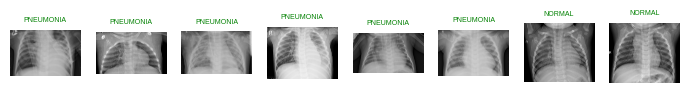

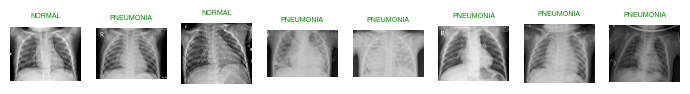

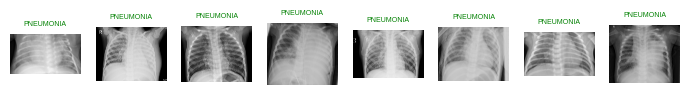

In [69]:
N_ROWS = 3
N_COLS = 8

for i in range(0, N_ROWS):
    fig, axs = plt.subplots(1, N_COLS, figsize=(7, 7))

    for j in range(N_COLS):
            id_j = np.random.randint(0, len(X_paths))
            img_path_i = X_paths[id_j]
            label_i = labels[id_j]
            img_i = cv2.imread(img_path_i, 0)

            axs[j].imshow(img_i, cmap='gray')
            axs[j].set_title(f"{label_i}", fontsize=5, color='green')
            axs[j].axis('off')

    fig.tight_layout()
    plt.show()

# Labels Preprocessing

In [70]:
def process_label(label):
    label = str(label).lower().strip()
    return label

In [71]:
labels_processed = [process_label(label) for label in tqdm.tqdm(labels, desc="Processing labels")]

Processing labels: 100%|██████████| 5856/5856 [00:00<00:00, 1567844.01it/s]


In [72]:
label_encoder = LabelEncoder()
label_encoder.fit(labels_processed)

LabelEncoder()

In [73]:
N_CLASSES = len(label_encoder.classes_)
print(f"Classes ({N_CLASSES}):", label_encoder.classes_)

Classes (2): ['normal' 'pneumonia']


In [74]:
y = label_encoder.transform(labels_processed)
y = np.array(y)

In [75]:
print(f"{y.shape = }")

y.shape = (5856,)


In [76]:
for i, count in Counter(y).items():
    print(f"Label {i:<2} ({label_encoder.classes_[i]:<9}): {count:<6} samples")

Label 1  (pneumonia): 4273   samples
Label 0  (normal   ): 1583   samples


# Images Preprocessing

Blur Filters

In [77]:
# make image smooth
def apply_filter_gaussian(image, kernel_size=(5, 5), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma).astype(image.dtype)

# remove salt and pepper noise
def apply_filter_median(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size).astype(image.dtype)

# preserve edges while reducing noise
def apply_filter_bilateral(image, d=9, sigma_color=75, sigma_space=75):
    return cv2.bilateralFilter(image, d, sigma_color, sigma_space).astype(image.dtype)

Edge Detection

In [78]:
def apply_laplacian(image, ksize=3):
    return cv2.Laplacian(image, cv2.CV_32F, ksize=ksize).astype(image.dtype)

def apply_sobel(image, dx=1, dy=0, ksize=3):
    return cv2.Sobel(image, cv2.CV_32F, dx, dy, ksize=ksize).astype(image.dtype)

def apply_canny(image, threshold1=50, threshold2=60):
    return cv2.Canny(image, threshold1, threshold2).astype(image.dtype)

Kmeans

In [79]:
def apply_kmeans(image, n_colors=12):
    n_channels = image.shape[2] if len(image.shape) == 3 else 1

    Z = image.reshape((-1, n_channels)).astype(np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, label, center = cv2.kmeans(Z, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
    res = center[label.flatten()]
    clustered = res.reshape(image.shape)
    return clustered

In [80]:
def preprocess_image_from_path(image_path):
    image = cv2.imread(image_path, 0)

    # Resize the image to the target dimensions
    image = cv2.resize(image, (IMG_H, IMG_W))

    # Ensure the image has channel dimension
    if len(image.shape) == 2:
        image = np.reshape(image, (IMG_H, IMG_W, 1))

    image = apply_filter_median(image)

    # append new channel for kmean
    image = np.stack((image, apply_sobel(image), apply_canny(image)), axis=-1)

    image = (image / 255.0).astype(np.float32)

    image = np.clip(image, 0.0, 1.0)

    return image.astype(np.float32)

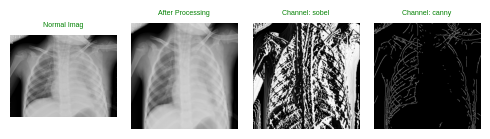

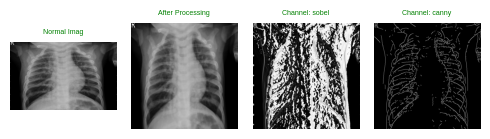

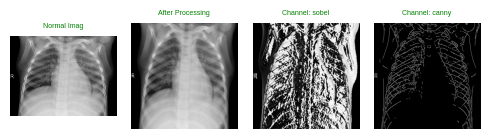

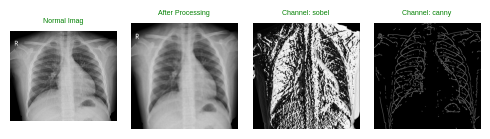

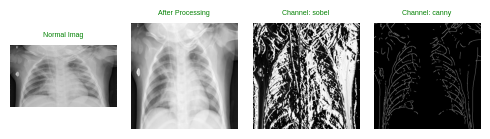

In [81]:
N_ROWS = 5
IMG_SHAPE = None

for i in range(0, N_ROWS):
    fig, axs = plt.subplots(1, 4, figsize=(5, 5))
    id_j = np.random.randint(0, len(X_paths))
    img_path_i = X_paths[id_j]
    label_i = labels[id_j]

    img_i = cv2.imread(img_path_i, 0)
    img_i_processed = preprocess_image_from_path(img_path_i)

    axs[0].imshow(img_i.squeeze(), cmap='gray')
    axs[0].set_title(f"Normal Imag", fontsize=5, color='green')
    axs[0].axis('off')

    axs[1].imshow(img_i_processed[:,:,0], cmap='gray')
    axs[1].set_title(f"After Processing", fontsize=5, color='green')
    axs[1].axis('off')

    axs[2].imshow(img_i_processed[:,:,1], cmap='gray')
    axs[2].set_title(f"Channel: sobel", fontsize=5, color='green')
    axs[2].axis('off')

    axs[3].imshow(img_i_processed[:,:,2], cmap='gray')
    axs[3].set_title(f"Channel: canny", fontsize=5, color='green')
    axs[3].axis('off')

    IMG_SHAPE = img_i_processed.shape

    fig.tight_layout()
    plt.show()

# Data Split

In [82]:
X_paths_train, X_paths_val, y_train, y_val = train_test_split(X_paths, y, test_size= VAL_SPLIT + TEST_SPLIT, random_state=42)

X_paths_val, X_path_test, y_val, y_test = train_test_split(X_paths_val, y_val, test_size= TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT), random_state=42)

X_paths_train = np.array(X_paths_train)
X_paths_val = np.array(X_paths_val)
X_paths_test = np.array(X_path_test)

print(f"{X_paths_train.shape = }")
print(f"{X_paths_val.shape = }")
print(f"{X_paths_test.shape = }")

X_paths_train.shape = (3513,)
X_paths_val.shape = (1171,)
X_paths_test.shape = (1172,)


# Data Augmentation

In [83]:
def custom_augmentation_numpy(image):
    # -----------------------------
    # 1. Random Horizontal Flip
    if np.random.rand() > 0.5:
        image = np.fliplr(image)

    # -----------------------------
    # 2. Random Vertical Flip
    if np.random.rand() > 0.5:
        image = np.flipud(image)

    # -----------------------------
    # 3. Random Rotation (-20 to 20 degrees)
    if np.random.rand() > 0.5:
        angle = np.random.uniform(-20, 20)
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)

    # -----------------------------
    # 4. Random Crop and Resize Back
    if np.random.rand() > 0.5:
        h, w = image.shape[:2]
        crop_scale = np.random.uniform(0.8, 1.0)
        new_h, new_w = int(h * crop_scale), int(w * crop_scale)
        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)
        image = image[top:top + new_h, left:left + new_w]
        image = cv2.resize(image, (w, h))

    # -----------------------------
    # 5. Random Brightness
    if np.random.rand() > 0.5:
        brightness_shift = np.random.uniform(-0.1, 0.1)
        image = image + brightness_shift
        image = np.clip(image, 0, 1)

    # -----------------------------
    # 6. Random Contrast
    if np.random.rand() > 0.5:
        factor = np.random.uniform(0.8, 1.2)
        mean = image.mean(axis=(0, 1), keepdims=True)
        image = (image - mean) * factor + mean
        image = np.clip(image, 0, 1)

    # -----------------------------
    # 7. Random Gaussian Noise
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.05, image.shape)
        image = image + noise
        image = np.clip(image, 0, 1)

    return image


In [84]:
class MyDataGenerator(Sequence):
    def __init__(self, images_paths, labels, batch_size=32, augment=True, shuffle=True, n_workers=4):
        self.images_paths = np.array(images_paths)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.n_workers = n_workers
        self.on_epoch_end()

        self._image_cache = dict()

    def __len__(self):
        return int(np.ceil(len(self.images_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images_paths = self.images_paths[batch_x]
        batch_labels = self.labels[batch_x]

        batch_images = self._load_images_parallel(batch_images_paths)

        if self.augment:
            batch_images = np.stack([custom_augmentation_numpy(img) for img in batch_images], axis=0)

        return batch_images, batch_labels

    def on_epoch_end(self):
        self.indices = np.arange(len(self.images_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _load_images_parallel(self, paths):
        with ThreadPoolExecutor(max_workers=self.n_workers) as executor:
            images = list(executor.map(self._load_and_preprocess_single, paths))
        return np.stack(images, axis=0)

    def _load_and_preprocess_single(self, path):
        return preprocess_image_from_path(path)

In [85]:
train_generator = MyDataGenerator(X_paths_train, y_train, batch_size=BATCH_SIZE, augment=True, shuffle=True)

train_pure_generator = MyDataGenerator(X_paths_train, y_train, batch_size=BATCH_SIZE, augment=False, shuffle=False)
val_generator = MyDataGenerator(X_paths_val, y_val, batch_size=BATCH_SIZE, augment=False, shuffle=False)
test_generator = MyDataGenerator(X_paths_test, y_test, batch_size=BATCH_SIZE, augment=False, shuffle=False)

# Model Encapsulation

In [86]:
CACHE_MODELS_DIR_NAME = os.path.join(BASE_DIR, 'models_cache')
os.makedirs(CACHE_MODELS_DIR_NAME, exist_ok=True)

In [87]:
class HistoryCheckpoint(Callback):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.filepath = os.path.join(CACHE_MODELS_DIR_NAME, f'{model_name}.history.json')
        self.history = {}

        if os.path.exists(self.filepath):
            with open(self.filepath, 'r') as f:
                self.history = json.load(f)
                print(F'Model {self.model_name} history loaded from cache')
        else:
            self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            self.history.setdefault(key, []).append(float(value))

        with open(self.filepath, 'w') as f:
            json.dump(self.history, f)

    def get_history(self):
        return self.history

In [88]:
class CustomModel:
    def __init__(self, name, model):
        self.name = re.sub('[^A-Za-z0-9]', '_', str(name)).lower()
        self.model = model

        self.y_train_hat = None
        self.y_val_hat = None
        self.y_test_hat = None

        self._history = {}

        self.load()

    def fit(self, data_gen, validation_data, epochs, batch_size, force_train= False, class_weights=None):
        file_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '.weights.h5'

        es = EarlyStopping(
            monitor='val_loss',
            patience=5,
            verbose=1,
            restore_best_weights=True
        )

        mcp = ModelCheckpoint(
            filepath=file_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,
            mode='min',
            verbose=1
        )

        rop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

        hcp = HistoryCheckpoint(self.name)

        if self.trained == False or force_train:
            history_callback = self.model.fit(data_gen,
                           validation_data = validation_data,
                           callbacks=[es, mcp, rop, hcp],
                           epochs = epochs,
                           batch_size = batch_size,
                           class_weight=class_weights)
            self.trained = True
            self._history = hcp.get_history() # Store history from callback
        else:
             self._history = hcp.get_history() # Load history from cache if not training


    @property
    def history(self):
        return self._history


    def prdict_on_train(self, x_train):
        if self.y_train_hat is None:
            self.y_train_hat = self.model.predict(x_train)
        return self.y_train_hat

    def prdict_on_val(self, x_val):
        if self.y_val_hat is None:
            self.y_val_hat = self.model.predict(x_val)
        return self.y_val_hat

    def prdict_on_test(self, x_test):
        if self.y_test_hat is None:
            self.y_test_hat = self.model.predict(x_test)
        return self.y_test_hat

    def save(self):
        file_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '.weights.h5'
        self.model.save_weights(file_path)

    def load(self):
        file_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '.weights.h5'

        if os.path.exists(file_path):
            self.model.load_weights(file_path)
            self.trained = True
            print(F'Model {self.name} weights loaded from cache')
        else:
            self.trained = False

# Models Arch

In [89]:
models_list = list()

In [90]:
def build_model_1():
    global models_list
    NAME = "simple_cnn_v1"


    model = Sequential()
    model.add(Input(shape= IMG_SHAPE))

    model.add(Conv2D(32, (3, 3), activation=None, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AvgPool2D((24, 24)))

    model.add(Flatten())

    model.add(Dense(32, activation='relu'))
    model.add(Dense(N_CLASSES, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    custom_model =  CustomModel(NAME, model)
    models_list = list(filter(lambda x: x.name != custom_model.name, models_list))
    models_list.append(custom_model)


build_model_1()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 512, 512, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512, 512, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 512, 512, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 21, 21, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 14112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │       451,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452,706 (1.73 MB)

 Trainable params: 452,642 (1.73 MB)

 Non-trainable params: 64 (256.00 B)

Model simple_cnn_v1 weights loaded from cache


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [91]:
def build_model_2():
    global models_list
    NAME = "medium_cnn_v1"


    model = Sequential()
    model.add(Input(shape= IMG_SHAPE))

    model.add(Conv2D(32, (3, 3), activation=None, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AvgPool2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation=None, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AvgPool2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation=None, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AvgPool2D((3, 3), strides=(3, 3)))

    model.add(Flatten())

    model.add(Dense(32, activation='relu'))
    model.add(Dense(N_CLASSES, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



    model.summary()
    custom_model =  CustomModel(NAME, model)
    models_list = list(filter(lambda x: x.name != custom_model.name, models_list))
    models_list.append(custom_model)

build_model_2()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 512, 512, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512, 512, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 512, 512, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_7             │ (None, 256, 256, 32)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_8             │ (None, 128, 128, 64)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_9             │ (None, 42, 42, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 225792)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │     7,225,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,319,586 (27.92 MB)

 Trainable params: 7,319,138 (27.92 MB)

 Non-trainable params: 448 (1.75 KB)

Model medium_cnn_v1 weights loaded from cache


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [92]:
def build_model_3():
    global models_list
    NAME = "long_cnn_v1"


    input_layer = Input(shape= IMG_SHAPE)

    branch_1 = Conv2D(32, (2, 2), activation=None, padding='same')(input_layer)
    branch_1 = BatchNormalization()(branch_1)
    branch_1 = Activation('relu')(branch_1)

    branch_2 = Conv2D(32, (6, 6), activation=None, padding='same')(input_layer)
    branch_2 = BatchNormalization()(branch_2)
    branch_2 = Activation('relu')(branch_2)

    z = Concatenate(axis=-1)([branch_1, branch_2])
    z = AvgPool2D((2, 2))(z)

    z = Conv2D(64, (3, 3), activation=None, padding='same')(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)

    z = Conv2D(128, (3, 3), activation=None, padding='same')(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)

    z = AvgPool2D((6, 6), strides=(6, 6))(z)

    z = Flatten()(z)

    z = Dense(64, activation='relu')(z)
    z = Dense(N_CLASSES, activation='softmax')(z)

    model = Model(inputs=input_layer, outputs=z)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



    model.summary()
    custom_model =  CustomModel(NAME, model)
    models_list = list(filter(lambda x: x.name != custom_model.name, models_list))
    models_list.append(custom_model)

build_model_3()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 512, 512,  │        416 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 512, 512,  │      3,488 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512, 512,  │          0 │ activation_12[0]… │
│ (Concatenate)       │ 64)               │            │ activation_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 256, 256,  │          0 │ concatenate_1[0]… │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 256, 256,  │     36,928 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 256, 256,  │     73,856 │ activation_14[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 42, 42,    │          0 │ activation_15[0]… │
│ (AveragePooling2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 225792)    │          0 │ average_pooling2

 Total params: 14,566,594 (55.57 MB)

 Trainable params: 14,566,082 (55.57 MB)

 Non-trainable params: 512 (2.00 KB)

Model long_cnn_v1 weights loaded from cache


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [93]:
for model in models_list:
    if isinstance(model.model, tf.keras.Model):
        try:
          keras_model = model.model

          img_path = os.path.join(CACHE_MODELS_DIR_NAME,f'{model.name}_arch.png')

          plot_model(
              keras_model,
              to_file= img_path,
              show_shapes=True,
              dpi =200,
              show_layer_names=True,
              expand_nested=True,
              show_layer_activations=True,
              show_trainable=True,
              show_dtype=True,
          )
        except:
          pass

"dot" with args ['-Tpng', '/tmp/tmpn4q_1_ui/tmp2lqch5nh'] returned code: -6

stdout, stderr:
 b''
b"failed at node 602[0]\ndot: maze.c:311: chkSgraph: Assertion `np->cells[0]' failed.\n"



# Model Training

In [94]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {i: class_weights[i] for i in range(len(class_weights))}

print(f"Class weights: {class_weights}")

Class weights: {0: np.float64(1.8927801724137931), 1: np.float64(0.6794970986460348)}


In [95]:
for i, model in enumerate(models_list):
    print(f"{i+1}. Train: {model.name}")
    model.fit(train_generator, val_generator, epochs= 50, batch_size= BATCH_SIZE, class_weights=class_weights, force_train=False)
    print('\n')

1. Train: simple_cnn_v1
Model simple_cnn_v1 history loaded from cache


2. Train: medium_cnn_v1
Model medium_cnn_v1 history loaded from cache


3. Train: long_cnn_v1
Model long_cnn_v1 history loaded from cache




# History

In [96]:
plt.style.use(plt.style.available[12])

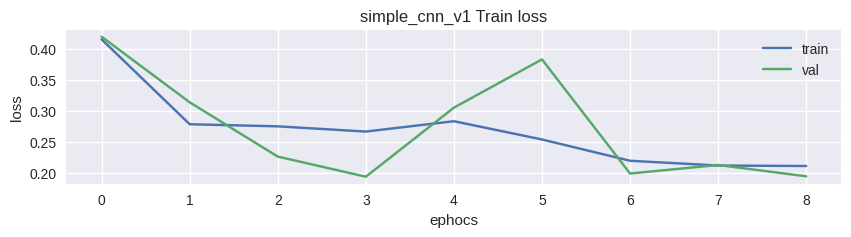

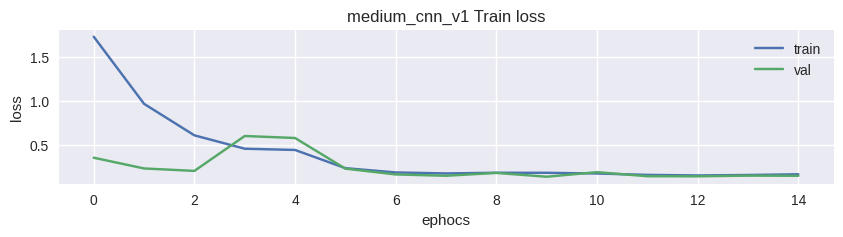

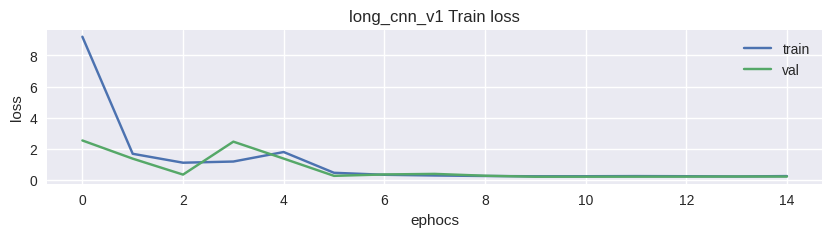

In [97]:
for i, model in enumerate(models_list):
    plt.figure(figsize=(10,2))
    plt.grid(True)
    plt.title(f"{model.name} Train loss")
    plt.ylabel('loss')
    plt.xlabel('ephocs')
    plt.plot(model.history['loss'], label='train')
    plt.plot(model.history['val_loss'], label='val')
    plt.legend()
    plt.show()

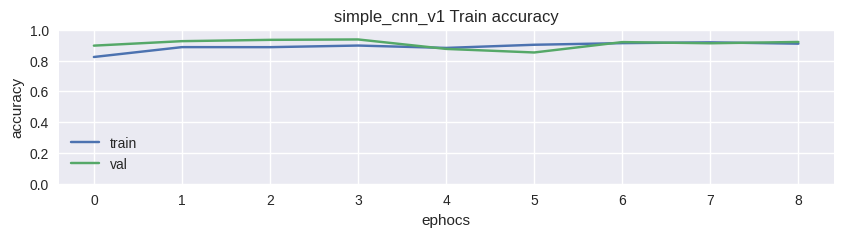

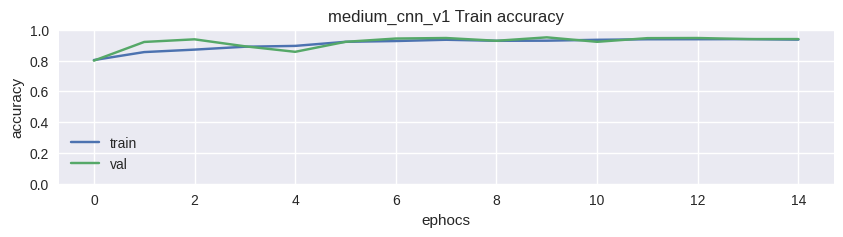

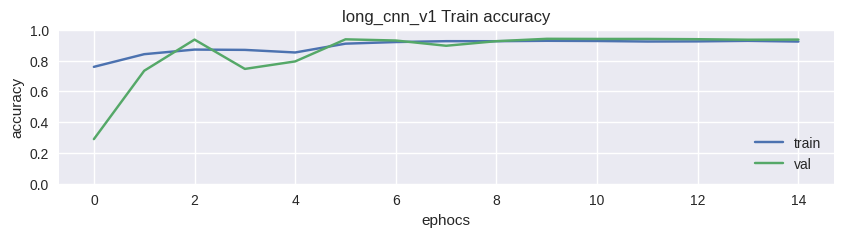

In [98]:
for i, model in enumerate(models_list):
    plt.figure(figsize=(10,2))
    plt.grid(True)
    plt.title(f"{model.name} Train accuracy")
    plt.ylabel('accuracy')
    plt.xlabel('ephocs')
    plt.plot(model.history['accuracy'], label='train')
    plt.plot(model.history['val_accuracy'], label='val')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

# Model Eval

In [99]:
# for model in models_list:
#     print(f"Model: {model.name}")

#     loss, accuracy = model.model.evaluate(train_pure_generator, verbose=0)
#     print(f"Train loss: {loss:.4f}")
#     print(f"Train accuracy: {accuracy:.4f}")

#     loss, accuracy = model.model.evaluate(val_generator, y_val, verbose=0)
#     print(f"Val loss: {loss:.4f}")
#     print(f"Val accuracy: {accuracy:.4f}")

#     loss, accuracy = model.model.evaluate(test_generator, y_test, verbose=0)
#     print(f"Test loss: {loss:.4f}")
#     print(f"Test accuracy: {accuracy:.4f}")

#     print("")


# Classification Report

Model: simple_cnn_v1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 60s 542ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 617ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 502ms/step


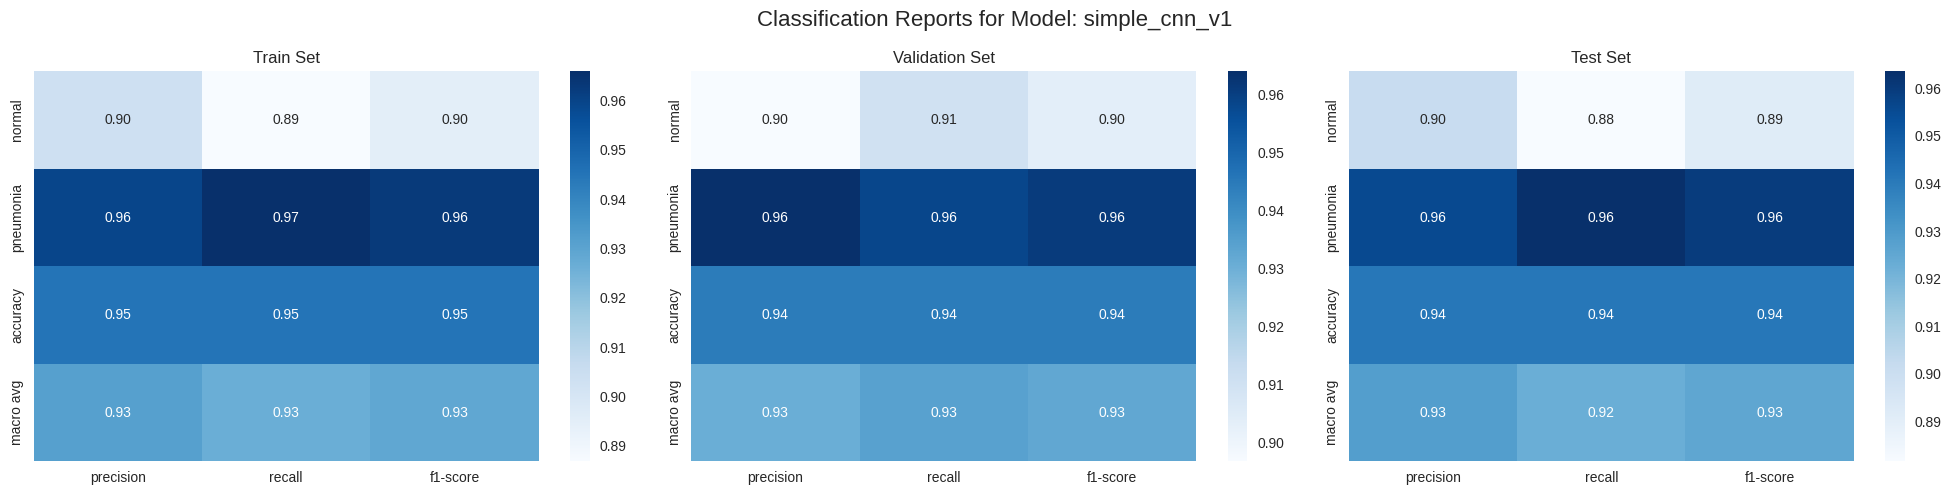

Model: medium_cnn_v1
110/110 ━━━━━━━━━━━━━━━━━━━━ 62s 519ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 24s 638ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 561ms/step


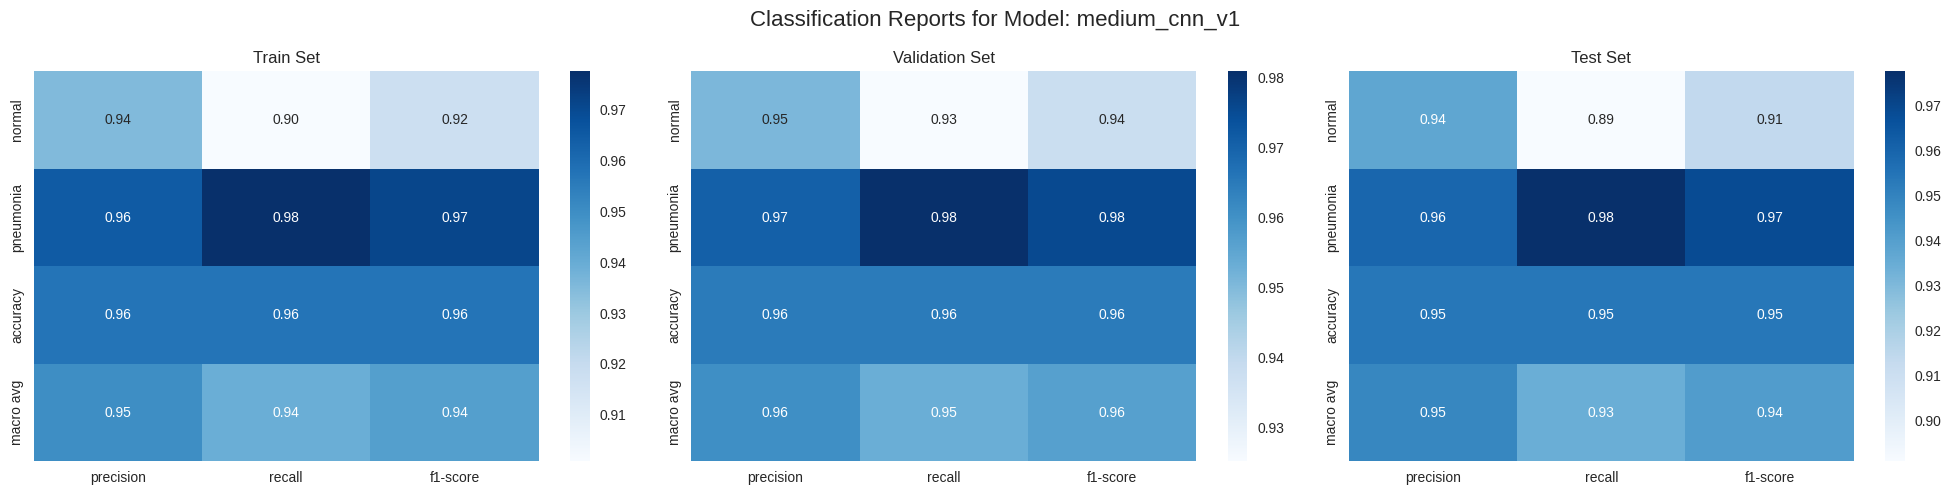

Model: long_cnn_v1
110/110 ━━━━━━━━━━━━━━━━━━━━ 74s 581ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 682ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 678ms/step


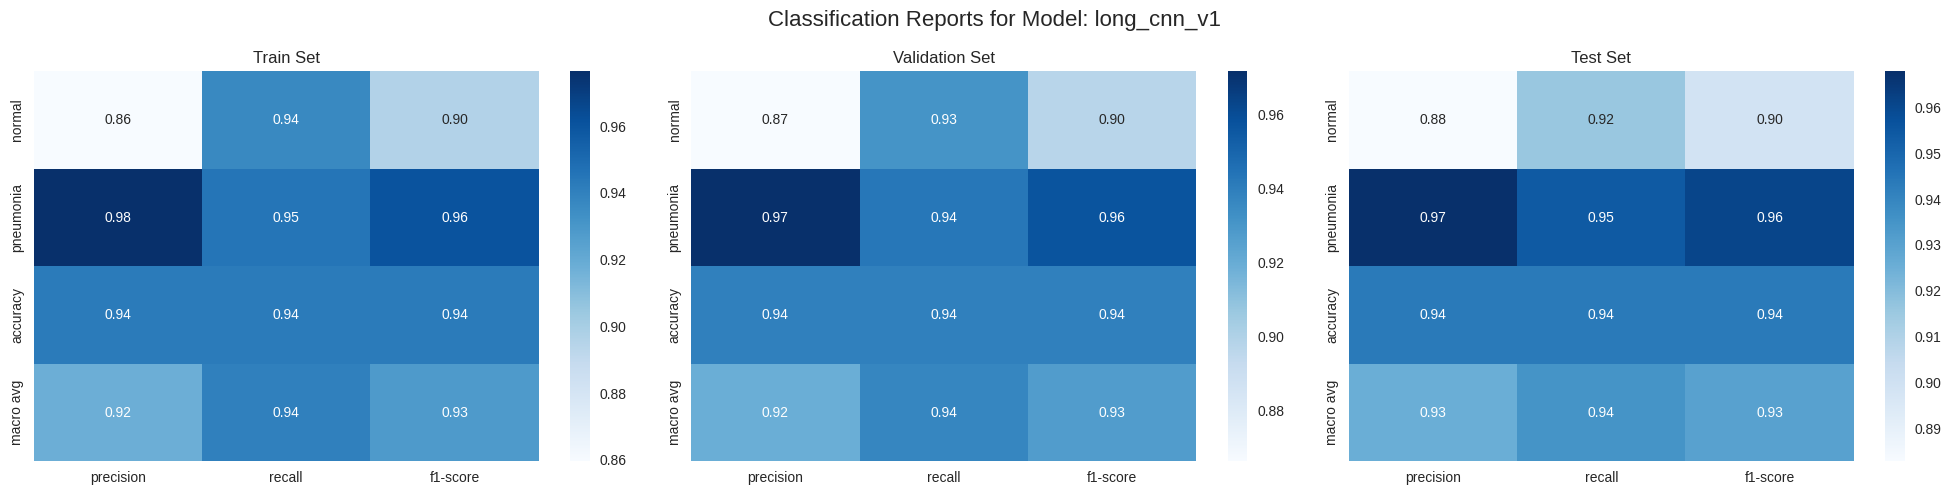

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

for model in models_list:
    print(f"Model: {model.name}")

    model.prdict_on_train(train_pure_generator)
    model.prdict_on_val(val_generator)
    model.prdict_on_test(test_generator)

    y_train_hat = np.argmax(model.y_train_hat, axis=1)
    y_val_hat = np.argmax(model.y_val_hat, axis=1)
    y_test_hat = np.argmax(model.y_test_hat, axis=1)

    # Prepare reports
    reports = {
        'Train': classification_report(y_train, y_train_hat, target_names=label_encoder.classes_, output_dict=True,zero_division=0),
        'Validation': classification_report(y_val, y_val_hat, target_names=label_encoder.classes_, output_dict=True,zero_division=0),
        'Test': classification_report(y_test, y_test_hat, target_names=label_encoder.classes_, output_dict=True,zero_division=0),
    }

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f'Classification Reports for Model: {model.name}', fontsize=16)

    for ax, (split, report_dict) in zip(axs, reports.items()):
        report_df = pd.DataFrame(report_dict).T.drop(columns=['support'], errors='ignore')
        sns.heatmap(report_df.iloc[:-1, :], annot=True, cmap='Blues', fmt='.2f', ax=ax)
        ax.set_title(f'{split} Set')
        ax.set_xlabel('')
        ax.set_ylabel('')

    plt.tight_layout()
    plt.show()


# Confusion Matrix

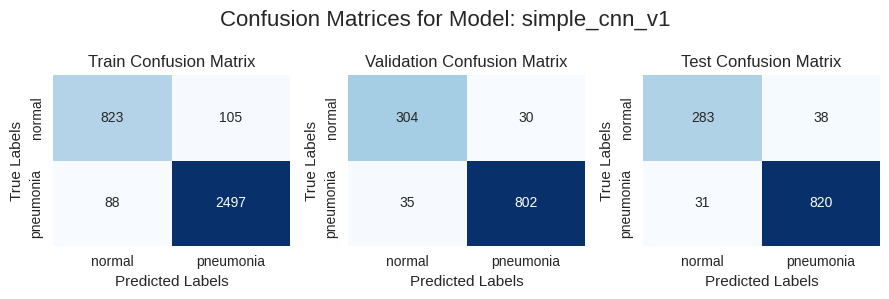

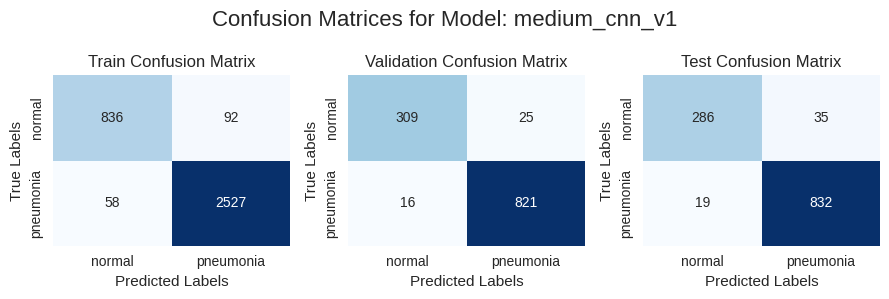

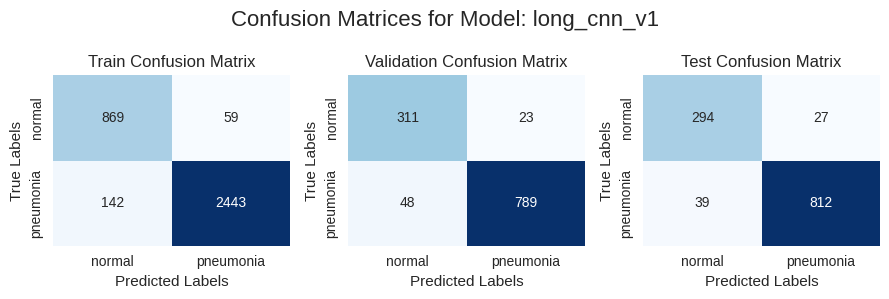

In [106]:
for model in models_list:
    y_train_hat = np.argmax(model.y_train_hat, axis=1)
    y_val_hat = np.argmax(model.y_val_hat, axis=1)
    y_test_hat = np.argmax(model.y_test_hat, axis=1)

    fig, axs = plt.subplots(1, 3, figsize=(9, 3))

    cm0 = confusion_matrix(y_train, y_train_hat)
    cm1 = confusion_matrix(y_val, y_val_hat)
    cm2 = confusion_matrix(y_test, y_test_hat)

    sns.heatmap(cm0, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    axs[0].set_title('Train Confusion Matrix')
    axs[0].set_xlabel('Predicted Labels')
    axs[0].set_ylabel('True Labels')

    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[1], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    axs[1].set_title('Validation Confusion Matrix')
    axs[1].set_xlabel('Predicted Labels')
    axs[1].set_ylabel('True Labels')

    sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[2], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    axs[2].set_title('Test Confusion Matrix')
    axs[2].set_xlabel('Predicted Labels')
    axs[2].set_ylabel('True Labels')

    fig.suptitle(f'Confusion Matrices for Model: {model.name}', fontsize=16)

    plt.tight_layout()
    plt.show()


# Depolyment

In [102]:
#nothing